# write CAFE60 $t_x$ transports

**Date:** <br>
16 May 2022 <br>
**Background:** <br>
Issue: https://github.com/csiro-dcfp/NCI-OOD-examples/issues/1<br>
**Author(s):**<br>
Thomas Moore<br>

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

# We are using NCI OOD as platform for data processing
### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

## Import packages

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## OOD cluster

In [3]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=48)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.171:36841,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Load CAFE data

## Define CAFE60 source files

In [5]:
file_ocean_month = '/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip'
file_ocean_bgc_month = '/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip'
file_ocean_daily = '/g/data/xv83/dcfp/CAFE60v1/ocean_daily.zarr.zip'
file_grid_spec = '/g/data/xv83/users/tm4888/data/CAFE/grid_spec.auscom.20110118.nc'
file_grid_info = '/g/data/xv83/users/tm4888/data/CAFE/CAFE60_ocean_grid_info.zarr'

## Load data objects including grid information

In [6]:
%%time
ds_CAFE60_ocean_month = xr.open_zarr(file_ocean_month,consolidated=True)
ds_CAFE60_ocean_bgc_month = xr.open_zarr(file_ocean_bgc_month,consolidated=True)
ds_CAFE60_ocean_daily = xr.open_zarr(file_ocean_daily,consolidated=True)
ds_CAFE60_grid = xr.open_zarr(file_grid_info,consolidated=True)

CPU times: user 11.9 s, sys: 1.21 s, total: 13.1 s
Wall time: 14.8 s


# Define some functions

## Climatology

In [7]:
def da_climatology(da,time_name='time'):
    clim = da.groupby(time_name+'.month').mean(dim=time_name)
    anom = da.groupby(time_name+'.month') - clim
    season = da.groupby(time_name+'.season').mean(dim=time_name)
    clim = clim.rename(clim.name+'_clim')
    anom = anom.rename(anom.name+'_anom')
    season = season.rename(season.name+'_season')
    return(clim,season,anom)

# Data reduction by region

## Define region

In [8]:
ens1 = 23
t1 = '2000-01-16' ; t2 = '2018-12-31'
x1=-250.0 ; x2=-70.0
y1=-25.0 ; y2=25.0
region_Tx_dict = {'ensemble':ens1,'time':slice(t1,t2),'xu_ocean':slice(x1,x2),'yt_ocean':slice(y1,y2)}

## Reduce data and report new size

In [9]:
tx_trans_reduced = ds_CAFE60_ocean_month.tx_trans.sel(region_Tx_dict)

In [10]:
print('reduced data is ' + str(tx_trans_reduced.nbytes/1e9) + 'GB')

reduced data is 0.907896GB


## Resize new, smaller chunks

In [11]:
tx_trans_reduced

,Array,Chunk
Bytes,865.84 MiB,233.32 kiB
Shape,"(228, 50, 110, 181)","(1, 3, 110, 181)"
Count,16304 Tasks,3876 Chunks
Type,float32,numpy.ndarray


### rechunk to chunk in space but include all depth and time in each chunk

In [12]:
tx_trans_reduced_unchunk_time_depth = tx_trans_reduced.chunk({'time':None,'st_ocean':None,'yt_ocean':50,'xu_ocean':50})

In [13]:
tx_trans_reduced_unchunk_time_depth

<xarray.DataArray 'tx_trans' (time: 228, st_ocean: 50, yt_ocean: 110, xu_ocean: 181)>
dask.array<rechunk-merge, shape=(228, 50, 110, 181), dtype=float32, chunksize=(228, 50, 50, 50), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 23
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) object 2000-01-16 12:00:00 ... 2018-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -250.0 -249.0 -248.0 ... -72.0 -71.0 -70.0
  * yt_ocean  (yt_ocean) float64 -24.6 -23.66 -22.74 -21.86 ... 22.74 23.66 24.6
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.0000000200408773e+20, 1.0000000200408773e+20]

# Compute climatology, anomaly, and seasonal climatology

In [14]:
%%time
[clim,season,anom] = da_climatology(tx_trans_reduced_unchunk_time_depth)

CPU times: user 224 ms, sys: 9.67 ms, total: 234 ms
Wall time: 232 ms


/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]


## rechunk climatologies to make more efficient (keep chunks around 100MB) 

In [20]:
clim = clim.chunk({'month':None,'st_ocean': None,'yt_ocean': None,'xu_ocean': None})
season = season.chunk({'season':None,'st_ocean': None,'yt_ocean': None,'xu_ocean': None})
anom = anom.chunk({'time':None,'st_ocean':None,'yt_ocean':50,'xu_ocean':50})

## Merge into dataset

In [22]:
Tx_clim_ds = xr.merge([clim,season,anom,tx_trans_reduced_unchunk_time_depth])

In [23]:
print('Merged dataset is ' + str(Tx_clim_ds.nbytes/1e9) + 'GB')

Merged dataset is 1.879508684GB


## Write to `zarr` 

In [25]:
%%time
Tx_clim_ds.to_zarr('/g/data/xv83/users/tm4888/data/CAFE/CAFE60_Tx_regional_clim.zarr')

CPU times: user 1min 42s, sys: 10.1 s, total: 1min 52s
Wall time: 6min 4s


# Sanity check

## load back in and make some plots

In [26]:
DS = xr.open_zarr('/g/data/xv83/users/tm4888/data/CAFE/CAFE60_Tx_regional_clim.zarr')

In [27]:
DS

<xarray.Dataset>
Dimensions:          (month: 12, season: 4, st_ocean: 50, time: 228, yt_ocean: 110, xu_ocean: 181)
Coordinates:
    ensemble         int32 ...
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * season           (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * st_ocean         (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time             (time) object 2000-01-16 12:00:00 ... 2018-12-16 12:00:00
  * xu_ocean         (xu_ocean) float64 -250.0 -249.0 -248.0 ... -71.0 -70.0
  * yt_ocean         (yt_ocean) float64 -24.6 -23.66 -22.74 ... 22.74 23.66 24.6
Data variables:
    tx_trans         (time, st_ocean, yt_ocean, xu_ocean) float32 dask.array<chunksize=(228, 50, 50, 50), meta=np.ndarray>
    tx_trans_anom    (time, st_ocean, yt_ocean, xu_ocean) float32 dask.array<chunksize=(228, 50, 50, 50), meta=np.ndarray>
    tx_trans_clim    (month, st_ocean, yt_ocean, xu_ocean) float32 dask.array<chunksize=(12, 50, 110, 181), meta=np.ndarray>
    tx_trans_season  (season, st_ocean, yt_ocean, xu_ocean) float32 dask.array<chunksize=(4, 50, 110, 181), meta=np.ndarray>

CPU times: user 625 ms, sys: 201 ms, total: 825 ms
Wall time: 682 ms


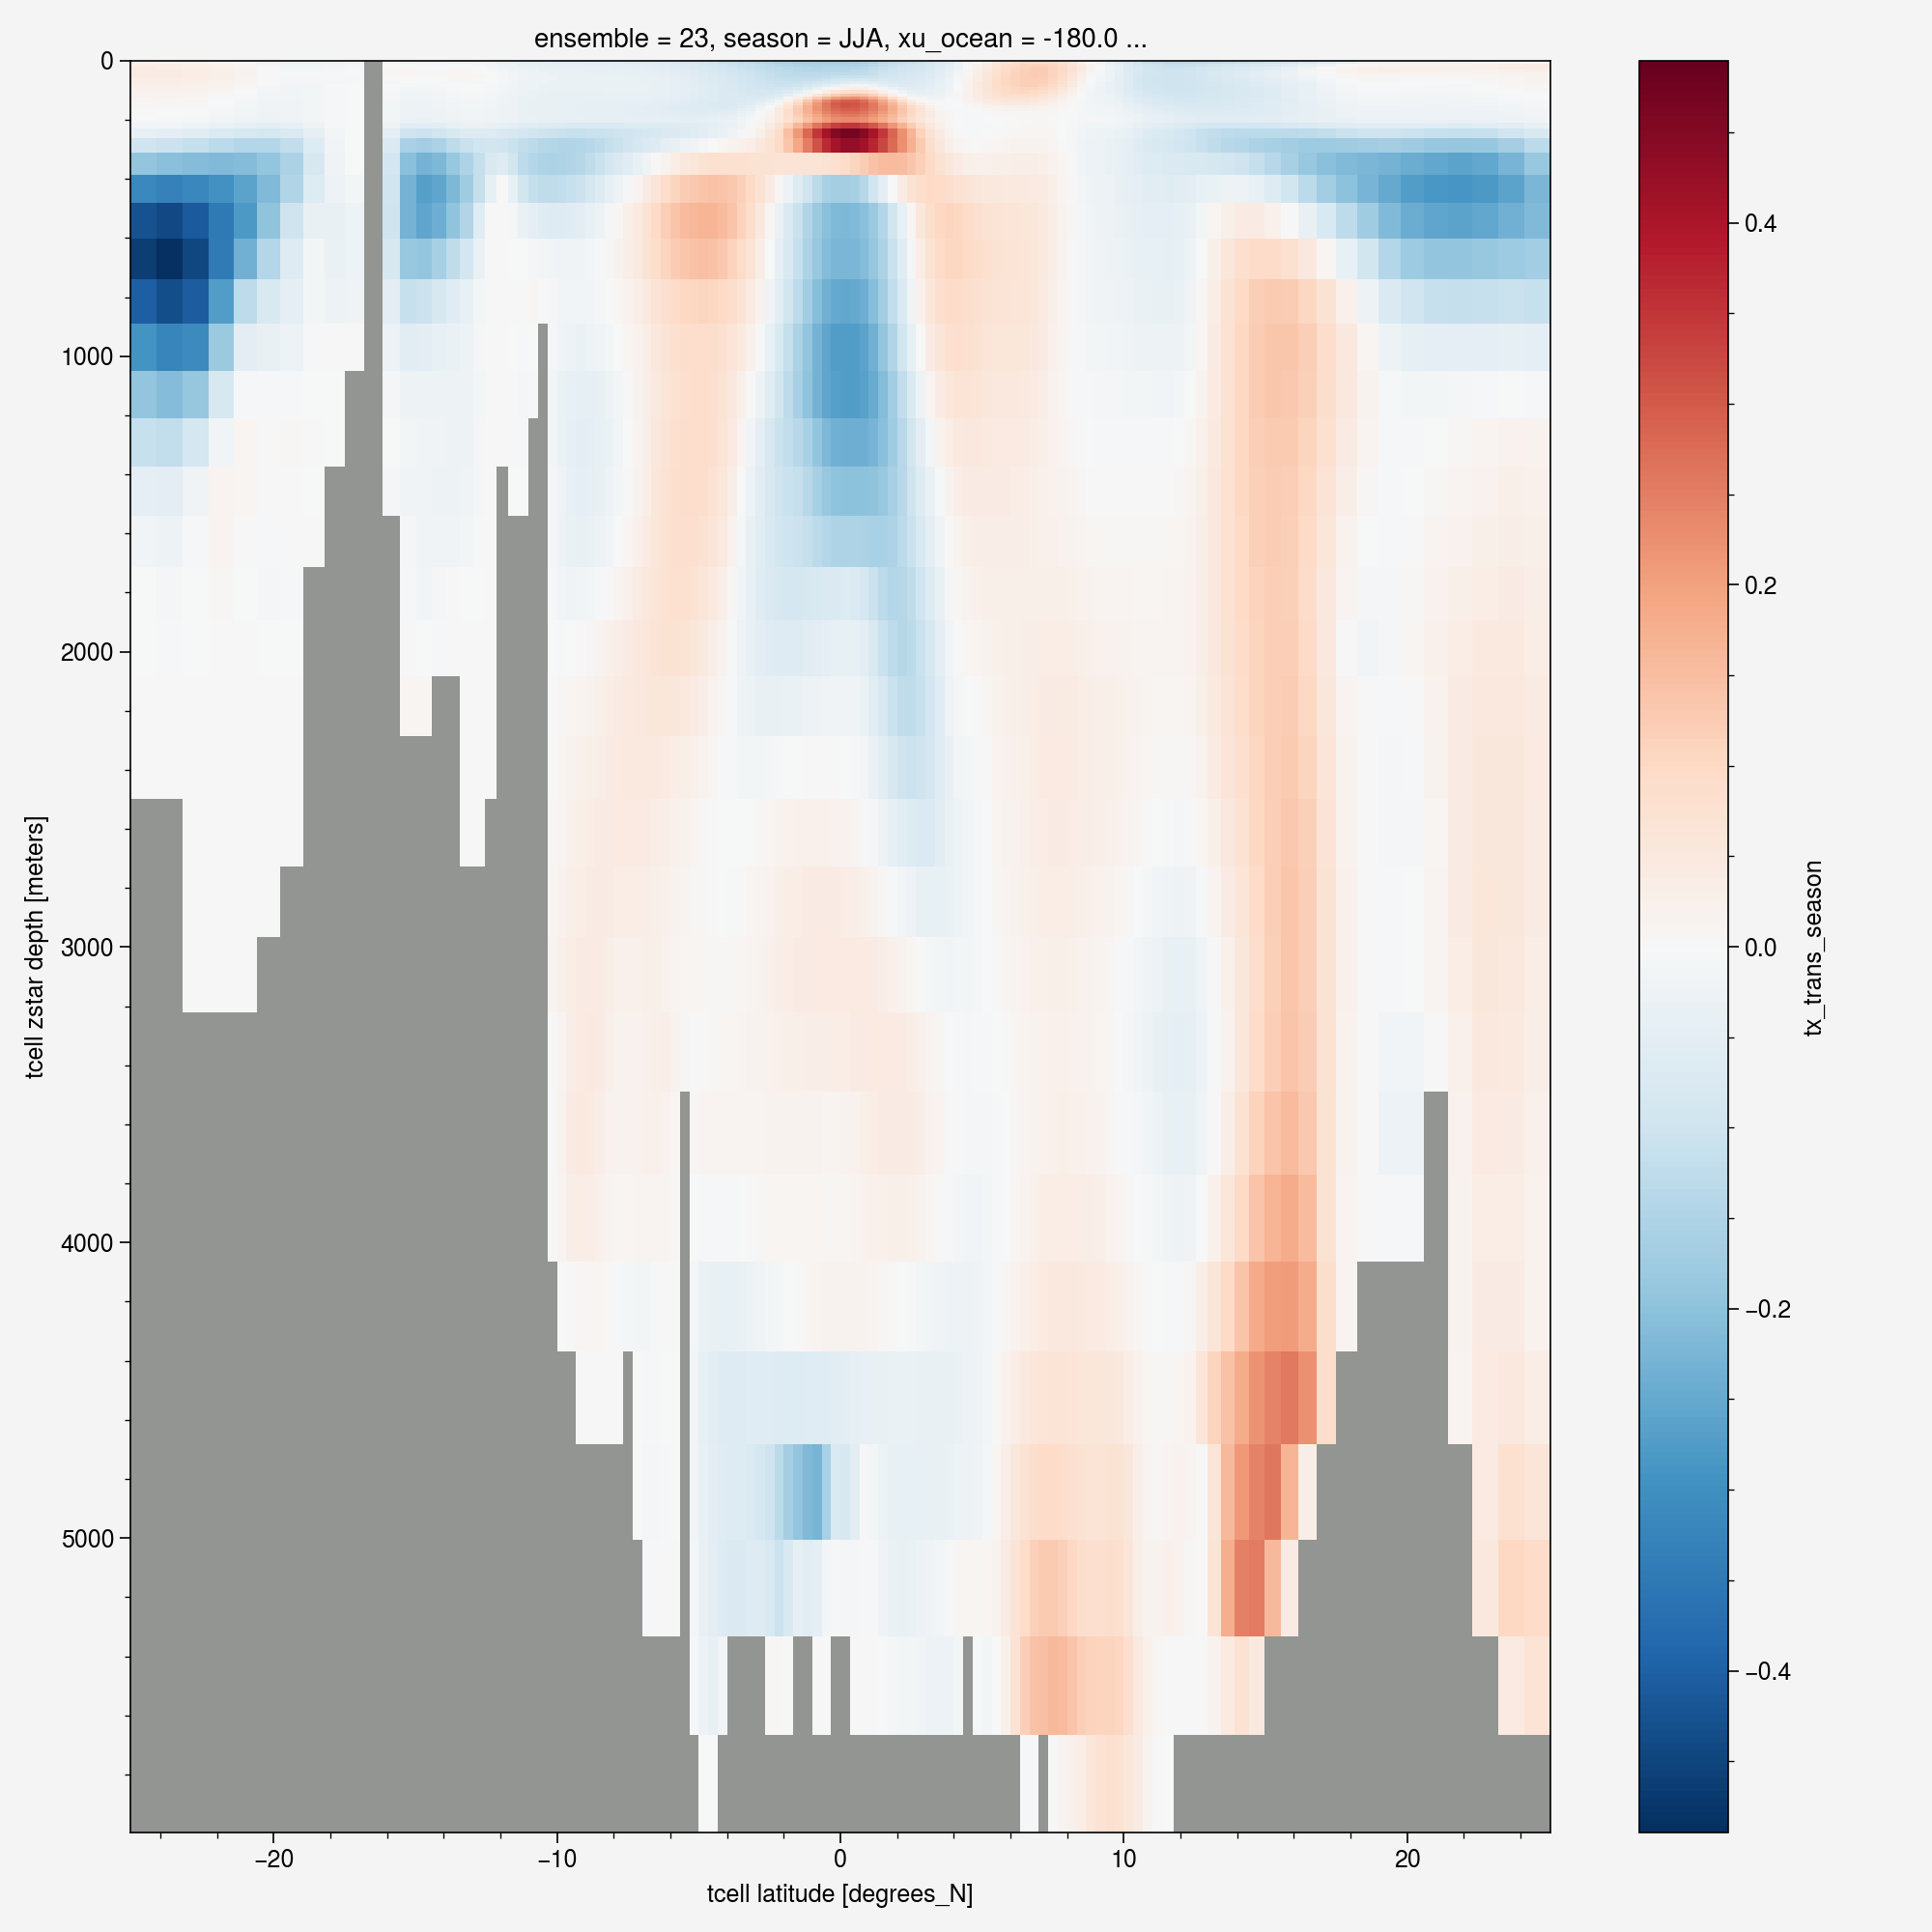

In [41]:
%%time
DS.tx_trans_season.isel(season=1).sel({'xu_ocean':-180},method='nearest').plot(size=10)
plt.gca().invert_yaxis()
ax = plt.gca()
ax.set_facecolor('grey')
plt.tight_layout()
plt.draw()

# $ The\ End$

## Break glass in case of emergency $\Downarrow$

In [ ]:
client.restart()

In [ ]:
client.shutdown()